In [56]:
import numpy as np
import pandas as pd
import time
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from tqdm import notebook

In [2]:
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
df = dataset['train'].to_pandas()
df.describe()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-2d735043be36d4ff/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [4]:
len(df['comment_id'].unique())

39565

In [5]:
len(df['annotator_id'].unique())

7912

In [6]:
df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [206]:
df[df['comment_id'] == 43625][['hate_speech_score', 'hatespeech']]

,hate_speech_score,hatespeech
3,0.26,0.0
24412,0.26,0.0
49310,0.26,2.0
70100,0.26,0.0


<Axes: >

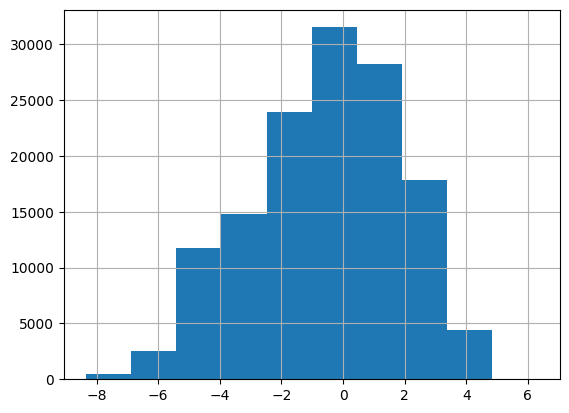

In [8]:
df['hate_speech_score'].hist()

In [202]:
df['hatespeech'].unique()

array([0., 2., 1.])

In [9]:
df[df['comment_id'] == 47101]['hate_speech_score']

2        0.36
25182    0.36
46708    0.36
69660    0.36
Name: hate_speech_score, dtype: float64

In [207]:
def get_agreement_score(x):
    mode_result = x.mode()
    mode_count = (x == mode_result.iloc[0]).sum()
    ln = len(x)
    
    return round(mode_count/ln*5)/5

In [210]:
text_df = df.groupby('comment_id', as_index=False).agg({'text': 'first', 'hate_speech_score': 'first', 'hatespeech': get_agreement_score})
text_df.columns = ['comment_id', 'text', 'hate_speech_score', 'annotator_agreement_factor']
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor
0,1,White people are trash.,0.46,1.0
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0


In [211]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   comment_id                  39565 non-null  int32  
 1   text                        39565 non-null  object 
 2   hate_speech_score           39565 non-null  float64
 3   annotator_agreement_factor  39565 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 1.1+ MB


In [214]:
def score_to_label(score):
  if score < -1:
    return 0
  if score > 0.5:
    return 2
  return 1

In [215]:
text_df['label'] = text_df['hate_speech_score'].apply(lambda x:score_to_label(x))
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor,label
0,1,White people are trash.,0.46,1.0,1
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6,1
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6,0
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4,1
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0,0


<Axes: >

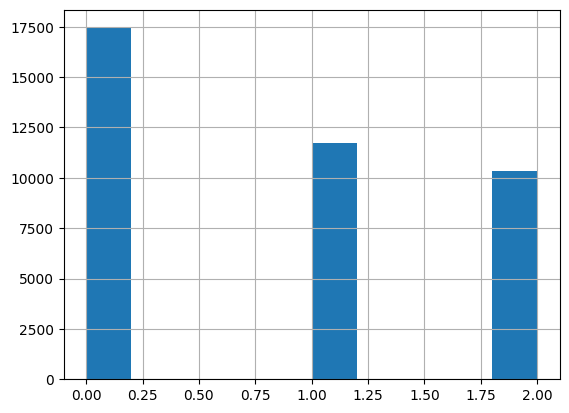

In [216]:
text_df['label'].hist()

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig

In [16]:
import os
import random

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [18]:
SEED = 9875
seed_everything(SEED)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


In [20]:
BERT = 'bert-base-uncased'
ROBERTA = 'roberta-base'

In [21]:
MODEL_NAME = ROBERTA

In [22]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(text_df[['comment_id', 'text']], text_df.label, test_size=0.2, random_state=SEED, stratify=text_df.label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [24]:
print(X_train.shape, y_train.shape)

(31652, 2) (31652,)


In [25]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [26]:
# train_df_0 = train_df[train_df['label'] == 0].sample(frac=0.3)
# train_df_1 = train_df[train_df['label'] == 1].sample(frac=0.3)
# train_df_2 = train_df[train_df['label'] == 2].sample(frac=0.3)
# train_df = pd.concat([train_df_0, train_df_1, train_df_2], axis=0).reset_index(drop=True)
# len(train_df)

In [27]:
train_df.head()

,comment_id,text,label
0,21596,Women so fucking retarded. Before you tell me ...,2
1,47578,kek those jews with their dumb little hats,2
2,42564,They rights alright right to go back to your c...,1
3,36607,you faggots wanna feed on this Daddy's cum?! URL,2
4,37035,@tcwittes She's not rejected her father who pr...,0


In [28]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [29]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
MAX_LEN = 256
EPOCHS = 5
LEARNING_RATE = 1e-05
NUM_LABELS = 3

In [30]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        text_id = self.df.loc[index, 'comment_id']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if MODEL_NAME=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids']
        else:
            token_type_ids = 1.

        target = self.df.loc[index, 'label']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long),
            'text_ids': text_id
        }

    def __len__(self):
        return self.len


In [31]:
train_data = TextDataset(train_df, tokenizer, MAX_LEN)
val_data = TextDataset(val_df, tokenizer, MAX_LEN)
test_data = TextDataset(test_df, tokenizer, MAX_LEN)

In [32]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [33]:
class HateSpeechClassifier(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name

        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768

        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(self.in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)

        output = self.layer_norm(output)
        output = self.dropout(output)
        output = self.classifier(output)
        # output = torch.nn.Softmax(output)
        return output

In [34]:
model = HateSpeechClassifier(MODEL_NAME)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HateSpeechClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [35]:
num_training_steps = EPOCHS*len(train_loader)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
num_warmup_steps = 0
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

In [36]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [37]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=5, evaluation=False):

    print("Training...\n")
    train_values = []
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        epoch_train_values = torch.empty(0, dtype=torch.float)

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            text_ids = batch['text_ids'].unsqueeze(1)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())

            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            softmax_values = torch.nn.functional.softmax(outputs, dim=1)

            batch_train_values = torch.cat((text_ids, softmax_values.cpu()), dim=1)
            epoch_train_values = torch.cat((epoch_train_values, batch_train_values), dim = 0)

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)

        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

            print("-"*70)

        train_values.append(epoch_train_values)
        print("\n")

    print("Training complete!")
    return train_values


In [38]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [39]:
train_values = train(model, loss_function, train_loader, val_loader, epochs=5, evaluation=True)

Training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.167526   |     -      |     -     |   17.55  
   1    |   40    |   1.112750   |     -      |     -     |   15.05  
   1    |   60    |   1.009465   |     -      |     -     |   15.01  
   1    |   80    |   0.953054   |     -      |     -     |   15.05  
   1    |   100   |   0.957226   |     -      |     -     |   15.17  
   1    |   120   |   0.951693   |     -      |     -     |   15.22  
   1    |   140   |   0.839855   |     -      |     -     |   15.24  
   1    |   160   |   0.901166   |     -      |     -     |   15.24  
   1    |   180   |   0.842374   |     -      |     -     |   15.26  
   1    |   200   |   0.841035   |     -      |     -     |   15.22  
   1    |   220   |   0.757637   |     -      |     -     |   15.22  
   1    |   240   |   0.859979   |     -      |     -     |   15.23  
   1  

In [40]:
test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
test_loss, test_accuracy

(0.7556916697611732, 67.92842741935483)

In [42]:
train_values2 = [0] * len(train_values)
for i, v in enumerate(train_values):
    train_values2[i] = v.cpu().detach().numpy()

In [68]:
train_values3 = []
for i, v in enumerate(train_values2):
    for j, row in notebook.tqdm(enumerate(v)):
        row1 = np.append(row, i+1)
        train_values3.append(row1)
        
train_values_np = np.stack(train_values3, axis=0)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [70]:
train_values_np.shape

(158260, 5)

In [223]:
train_values_df = pd.DataFrame(train_values_np, columns=['comment_id', 'label_0', 'label_1', 'label_2', 'epoch_no'])
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,5727.0,0.214177,0.387880,0.397943,1.0
1,17404.0,0.274503,0.607368,0.118130,1.0
2,11656.0,0.246864,0.673450,0.079685,1.0
3,37337.0,0.376657,0.516165,0.107178,1.0
4,26559.0,0.176695,0.629456,0.193849,1.0


In [224]:
train_values_df['comment_id'] = train_values_df['comment_id'].astype(int)
train_values_df['epoch_no'] = train_values_df['epoch_no'].astype(int)
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,5727,0.214177,0.387880,0.397943,1
1,17404,0.274503,0.607368,0.118130,1
2,11656,0.246864,0.673450,0.079685,1
3,37337,0.376657,0.516165,0.107178,1
4,26559,0.176695,0.629456,0.193849,1


In [225]:
train_values_df = pd.merge(train_values_df, text_df[['comment_id', 'label', 'hate_speech_score', 'annotator_agreement_factor']], on='comment_id', how='left')
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor
0,5727,0.214177,0.387880,0.397943,1,1,-0.30,0.6
1,17404,0.274503,0.607368,0.118130,1,2,0.58,1.0
2,11656,0.246864,0.673450,0.079685,1,2,2.40,1.0
3,37337,0.376657,0.516165,0.107178,1,0,-3.19,1.0
4,26559,0.176695,0.629456,0.193849,1,0,-3.05,1.0


In [226]:
def get_pred(label_0, label_1, label_2):
    if label_0> label_1 and label_0 > label_2:
        return 0
    elif label_1> label_0 and label_1 > label_2:
        return 1
    else:
        return 2

In [227]:
train_values_df['pred'] = train_values_df.apply(lambda row: get_pred(row.label_0, row.label_1, row.label_2), axis=1)

In [228]:
train_values_df.tail()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor,pred
158255,20472,0.483503,0.454482,0.062015,5,2,0.66,1.0,0
158256,7060,0.997720,0.002197,0.000082,5,0,-3.52,1.0,0
158257,13524,0.856789,0.140528,0.002684,5,0,-1.14,1.0,0
158258,45063,0.075989,0.540550,0.383461,5,2,0.71,0.4,1
158259,43598,0.760194,0.219929,0.019877,5,1,-0.16,0.4,0


In [229]:
train_values_agg_df = train_values_df.sort_values(['epoch_no']).groupby('comment_id', as_index=False).agg({'label_0': ['mean', 'std', 'last'], 'label_1': ['mean', 'std', 'last'], 'label_2': ['mean', 'std', 'last'], 'label': 'first', 'hate_speech_score': 'first', 'pred': 'last', 'annotator_agreement_factor': 'first'})

In [230]:
train_values_agg_df.head()

comment_id   label_0                       label_1                      \
                  mean       std      last      mean       std      last   
0          4  0.327076  0.092245  0.355685  0.541535  0.083422  0.419785   
1          5  0.988552  0.009476  0.997781  0.010605  0.008972  0.002175   
2          6  0.116653  0.125587  0.026715  0.323369  0.200302  0.359787   
3          7  0.118732  0.033541  0.139646  0.426261  0.240786  0.623640   
4          8  0.279110  0.165139  0.252570  0.482119  0.162790  0.623285   

    label_2                     label hate_speech_score pred  \
       mean       std      last first             first last   
0  0.131389  0.067295  0.224530     1             -0.24    1   
1  0.000843  0.000661  0.000044     0             -2.84    0   
2  0.559977  0.196508  0.613498     2              1.72    2   
3  0.455007  0.266444  0.236714     1             -0.77    1   
4  0.238772  0.107405  0.124145     2              1.24    1   

  annotator_agreement_factor  
                       first  
0                        0.4  
1                        1.0  
2                        1.0  
3                        0.6  
4                        1.0

In [231]:
train_values_agg_df.columns = ['comment_id', 'label_0_mean', 'label_0_std', 'label_0_last', 'label_1_mean', 'label_1_std', 'label_1_last', 'label_2_mean', 'label_2_std', 'label_2_last', 'label', 'hate_speech_score', 'pred', 'annotator_agreement_factor']
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor
0,4,0.327076,0.092245,0.355685,0.541535,0.083422,0.419785,0.131389,0.067295,0.224530,1,-0.24,1,0.4
1,5,0.988552,0.009476,0.997781,0.010605,0.008972,0.002175,0.000843,0.000661,0.000044,0,-2.84,0,1.0
2,6,0.116653,0.125587,0.026715,0.323369,0.200302,0.359787,0.559977,0.196508,0.613498,2,1.72,2,1.0
3,7,0.118732,0.033541,0.139646,0.426261,0.240786,0.623640,0.455007,0.266444,0.236714,1,-0.77,1,0.6
4,8,0.279110,0.165139,0.252570,0.482119,0.162790,0.623285,0.238772,0.107405,0.124145,2,1.24,1,1.0


In [232]:
def get_confidence(label, label_0_mean, label_1_mean, label_2_mean):
    if label == 0:
        return label_0_mean
    elif label == 1:
        return label_1_mean
    else: return label_2_mean
    
def get_variability(label, label_0_std, label_1_std, label_2_std):
    if label == 0:
        return label_0_std
    elif label == 1:
        return label_1_std
    else: return label_2_std

def get_correctness(label, label_0_last, label_1_last, label_2_last):
    if label == 0:
        return round(label_0_last*5)/5
    elif label == 1:
        return round(label_1_last*5)/5
    else: return round(label_2_last*5)/5

In [233]:
train_values_agg_df['confidence'] = train_values_agg_df.apply(lambda row: get_confidence(row.label, row.label_0_mean, row.label_1_mean, row.label_2_mean), axis=1)
train_values_agg_df['variability'] = train_values_agg_df.apply(lambda row: get_variability(row.label, row.label_0_std, row.label_1_std, row.label_2_std), axis=1)
train_values_agg_df['correctness'] = train_values_agg_df.apply(lambda row: get_correctness(row.label, row.label_0_last, row.label_1_last, row.label_2_last), axis=1)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness
0,4,0.327076,0.092245,0.355685,0.541535,0.083422,0.419785,0.131389,0.067295,0.224530,1,-0.24,1,0.4,0.541535,0.083422,0.4
1,5,0.988552,0.009476,0.997781,0.010605,0.008972,0.002175,0.000843,0.000661,0.000044,0,-2.84,0,1.0,0.988552,0.009476,1.0
2,6,0.116653,0.125587,0.026715,0.323369,0.200302,0.359787,0.559977,0.196508,0.613498,2,1.72,2,1.0,0.559977,0.196508,0.6
3,7,0.118732,0.033541,0.139646,0.426261,0.240786,0.623640,0.455007,0.266444,0.236714,1,-0.77,1,0.6,0.426261,0.240786,0.6
4,8,0.279110,0.165139,0.252570,0.482119,0.162790,0.623285,0.238772,0.107405,0.124145,2,1.24,1,1.0,0.238772,0.107405,0.2


In [234]:
train_values_agg_df['is_correct'] = np.where((train_values_agg_df['label'] == train_values_agg_df['pred']), True, False)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness,is_correct
0,4,0.327076,0.092245,0.355685,0.541535,0.083422,0.419785,0.131389,0.067295,0.224530,1,-0.24,1,0.4,0.541535,0.083422,0.4,True
1,5,0.988552,0.009476,0.997781,0.010605,0.008972,0.002175,0.000843,0.000661,0.000044,0,-2.84,0,1.0,0.988552,0.009476,1.0,True
2,6,0.116653,0.125587,0.026715,0.323369,0.200302,0.359787,0.559977,0.196508,0.613498,2,1.72,2,1.0,0.559977,0.196508,0.6,True
3,7,0.118732,0.033541,0.139646,0.426261,0.240786,0.623640,0.455007,0.266444,0.236714,1,-0.77,1,0.6,0.426261,0.240786,0.6,True
4,8,0.279110,0.165139,0.252570,0.482119,0.162790,0.623285,0.238772,0.107405,0.124145,2,1.24,1,1.0,0.238772,0.107405,0.2,False


In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

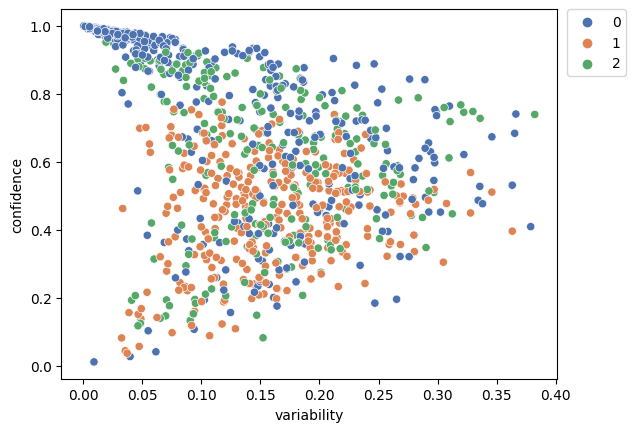

In [236]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='pred', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

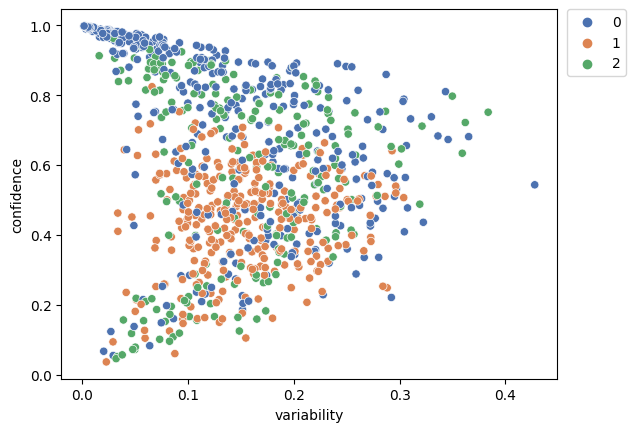

In [237]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='label', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

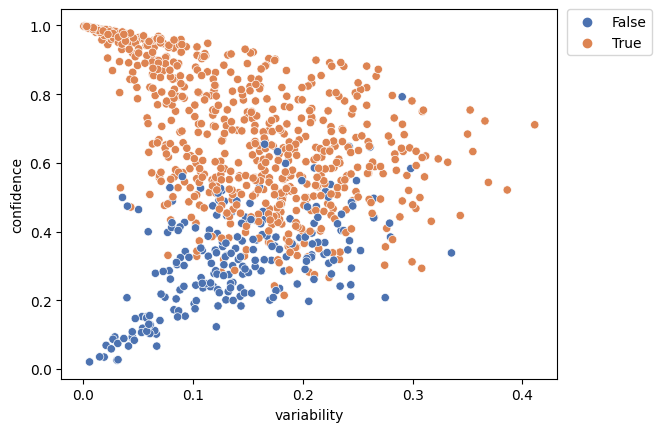

In [238]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='is_correct', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

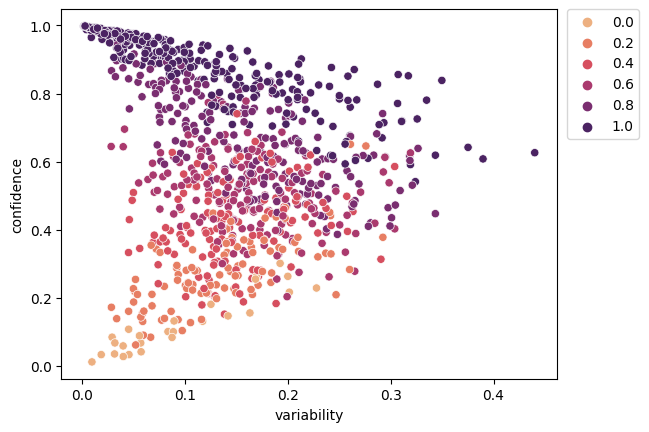

In [239]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='correctness', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

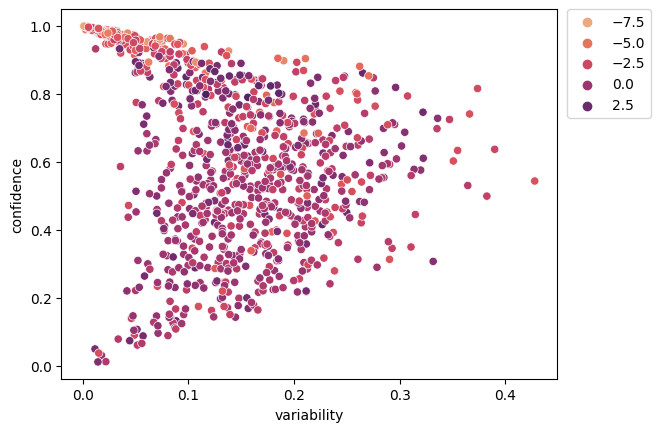

In [240]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='hate_speech_score', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

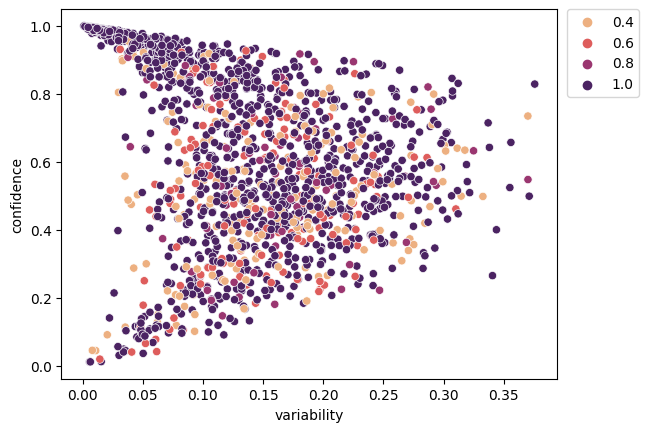

In [244]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.05), x="variability", y="confidence", hue='annotator_agreement_factor', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: >

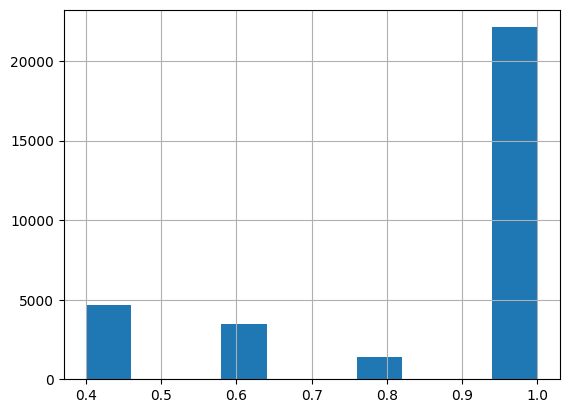

In [242]:
train_values_agg_df['annotator_agreement_factor'].hist()